In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define ODEs
def VanDerPol(y, t, mu):
    x, y = y
    #dxdt = y
    #dydt = epsilon * (1 - x**2) * y - x
    dxdt = mu * (x - (1/3) * x**3 - y)
    dydt = (1/mu) * x
    return [dxdt, dydt]

In [3]:
'''
y0 = [0.002, 0.0]
t = np.linspace(0, 120, 100)  
epsilon = -0.1 
'''
y0 = [2, 0]
t = np.linspace(0, 40, 100)  
#epsilon = 0.01
mu = 10

In [4]:
# solve ODEs
x_real, y_real = odeint(VanDerPol, y0, t, args=(mu,)).T
# tranform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float32)
x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)

In [5]:
'''
def input_transform(t_tensor):
    sin_cos_features = [torch.sin(n * t_tensor) for n in range(1, 3)] + \
                       [torch.cos(n * t_tensor) for n in range(1, 3)] + \
                       [-torch.sin(n * t_tensor) for n in range(1, 3)] 
    return torch.cat([t_tensor] + sin_cos_features, dim=1)
'''
def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

In [6]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        self.fc1 = nn.Linear(1, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, t):
        t = input_transform(t)  
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
def loss_func(model, t_tensor, x_real, y_real, x0, y0, mu, random_points=10):
    
    t_tensor.requires_grad = True
    pred = model(t_tensor)
    x_pred, y_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1)

    dx_dt = torch.autograd.grad(x_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred.sum(), t_tensor, retain_graph=True, create_graph=True)[0]

    #residual1 = dx_dt - y_pred
    #residual2 = dy_dt - (epsilon *(1 - x_pred**2) * y_pred - x_pred)
    residual1 = dx_dt - mu * (x_pred - (1/3) * x_pred**3 - y_pred)
    residual2 = dy_dt - (1/mu) * x_pred
    
    init_loss = torch.square(x_pred[0] - x0) + torch.square(y_pred[0] - y0)
    physics_loss = torch.mean(residual1**2 + residual2**2)
    #data_loss = torch.mean((pred_x - x_real)**2 + (pred_y - y_real)**2)
    random_indices = torch.randint(0, x_real.shape[0], (random_points,))
    data_loss = torch.mean((x_pred[random_indices] - x_real[random_indices])**2 + 
                           (y_pred[random_indices] - y_real[random_indices])**2)
    
    #adjust weights
    total_loss = physics_loss + 0.01*init_loss + 10*data_loss
    #total_loss = data_loss
    return total_loss

Epoch 0, Loss: 35.78163146972656
Epoch 1000, Loss: 22.12397575378418
Epoch 2000, Loss: 20.664310455322266
Epoch 3000, Loss: 20.65590476989746
Epoch 4000, Loss: 14.54612922668457
Epoch 5000, Loss: 6.0254950523376465
Epoch 6000, Loss: 10.909372329711914
Epoch 7000, Loss: 3.375537157058716
Epoch 8000, Loss: 0.9173182249069214
Epoch 9000, Loss: 1.7809488773345947
Epoch 10000, Loss: 4.563276290893555
Epoch 11000, Loss: 1.0962648391723633
Epoch 12000, Loss: 1.399686336517334
Epoch 13000, Loss: 5.944057464599609
Epoch 14000, Loss: 1.6559828519821167
Epoch 15000, Loss: 2.493201732635498
Epoch 16000, Loss: 2.9307408332824707
Epoch 17000, Loss: 0.9721778035163879
Epoch 18000, Loss: 5.266150951385498
Epoch 19000, Loss: 2.7645134925842285
Epoch 20000, Loss: 2.122197389602661
Epoch 21000, Loss: 2.3735554218292236
Epoch 22000, Loss: 2.4826955795288086
Epoch 23000, Loss: 0.5064857006072998
Epoch 24000, Loss: 0.4307093918323517
Epoch 25000, Loss: 0.595156192779541
Epoch 26000, Loss: 1.3314290046691895

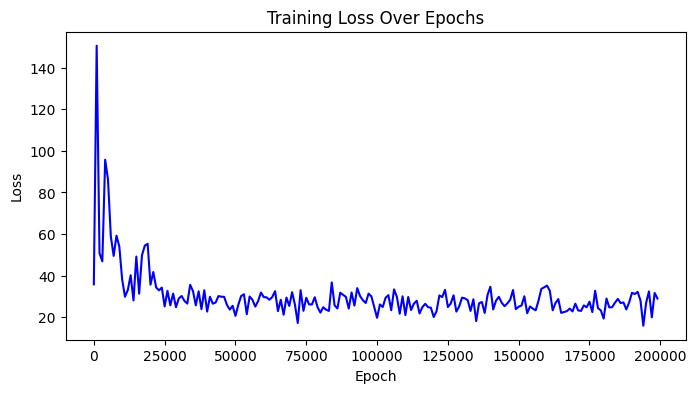

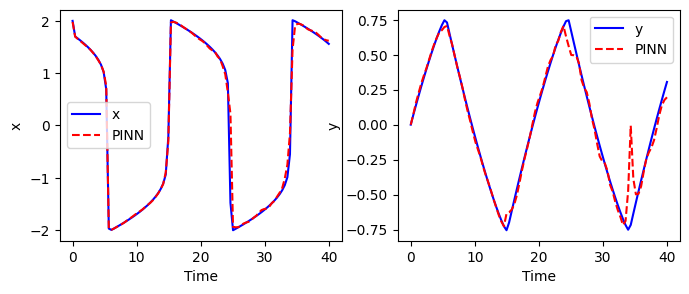

In [8]:
if __name__=='__main__':

    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_values = []
    epoch_num = 200000
    for epoch in range(epoch_num):

        loss = loss_func(model, t_tensor, x_real_tensor, y_real_tensor, y0[0], y0[1], mu, random_points=10)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_values.append(loss.item())
        
    plt.figure(figsize=(8, 4))
    plt.plot(range(0, epoch_num, 1000), loss_values[:epoch_num//1000], 'b-')  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()



    # model evaluation
    model.eval()
    with torch.no_grad():
        x_pred, y_pred = model(t_tensor).numpy().T
    
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(t, x_real, 'b-', label='x')
    plt.plot(t, x_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(t, y_real, 'b-', label='y')
    plt.plot(t, y_pred, 'r--', label='PINN')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

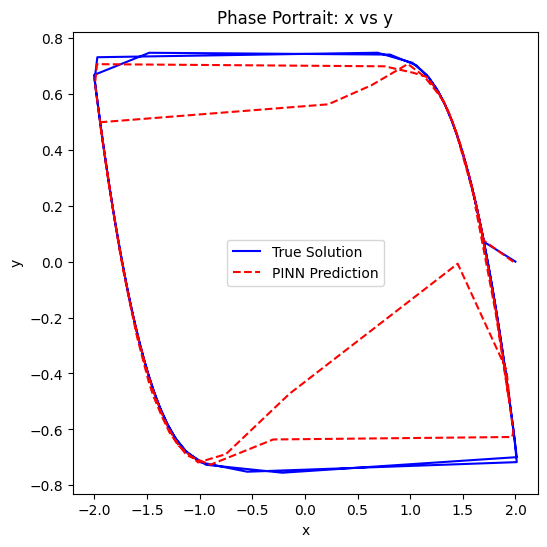

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(x_real, y_real, 'b-', label='True Solution')
plt.plot(x_pred, y_pred, 'r--', label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Portrait: x vs y')
plt.legend()
plt.show()